In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import ToPILImage
import random

import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else cpu)

seed = 2002
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print(device)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-02 02:42:52.037305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 02:42:52.037400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 02:42:52.163237: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
cuda:0


In [2]:
df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df['pixel774'].unique()

array([  0, 194, 213, 253,  98,  61, 252, 191,  27,   6, 157, 135,  28,
       108,  49,  20,  38, 226, 128,  41,  60,  18,  95,  82,  63,  43,
         3, 218, 105,  75,  36, 192, 212, 254, 183, 117,  99,  89, 204,
       125,  17, 247, 190, 151,  44, 111,  97, 234, 249,  84,  19, 129,
        80, 122,  79, 223,  30])

In [5]:
df.loc[:, df.columns != 'label'] = df.loc[:, df.columns != 'label'] / 255.0

In [6]:
df['pixel774'].unique()

array([0.        , 0.76078431, 0.83529412, 0.99215686, 0.38431373,
       0.23921569, 0.98823529, 0.74901961, 0.10588235, 0.02352941,
       0.61568627, 0.52941176, 0.10980392, 0.42352941, 0.19215686,
       0.07843137, 0.14901961, 0.88627451, 0.50196078, 0.16078431,
       0.23529412, 0.07058824, 0.37254902, 0.32156863, 0.24705882,
       0.16862745, 0.01176471, 0.85490196, 0.41176471, 0.29411765,
       0.14117647, 0.75294118, 0.83137255, 0.99607843, 0.71764706,
       0.45882353, 0.38823529, 0.34901961, 0.8       , 0.49019608,
       0.06666667, 0.96862745, 0.74509804, 0.59215686, 0.17254902,
       0.43529412, 0.38039216, 0.91764706, 0.97647059, 0.32941176,
       0.0745098 , 0.50588235, 0.31372549, 0.47843137, 0.30980392,
       0.8745098 , 0.11764706])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: float64(708), int64(77)
memory usage: 251.5 MB


In [8]:
df.isna().sum().sum()

0

In [9]:
class DigitDataset(Dataset):
    def __init__(self, features, target=None, augment=False):
        self.features = features
        self.target = target
        self.augment = augment

        if self.augment:
            self.transforms = transforms.Compose([
                #transforms.ToPILImage(),  
                transforms.RandomRotation(degrees=15),
                transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
                #transforms.ColorJitter(brightness=0.1, contrast=0.1),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))  
            ])
        else:
            self.transforms = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))  
            ])

    def __len__(self):
        if self.target is None:
            return len(self.features)
        else:
            return len(self.target)

    def __getitem__(self, idx):
        features_tensor = torch.tensor(self.features.iloc[idx].values, dtype=torch.float).view(1, 28, 28)
        features_pil = ToPILImage()(features_tensor)
        features_tensor = self.transforms(features_pil)

        if self.target is not None:
            label_tensor = torch.tensor(self.target.iloc[idx], dtype=torch.long)
            return features_tensor, label_tensor
        else:
            return features_tensor



In [10]:
dataset = DigitDataset(df.drop(['label'], axis=1), df['label'], True)

In [11]:
classes = sorted(df['label'].unique())
classes

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [13]:
for features, label in dataloader:
    break

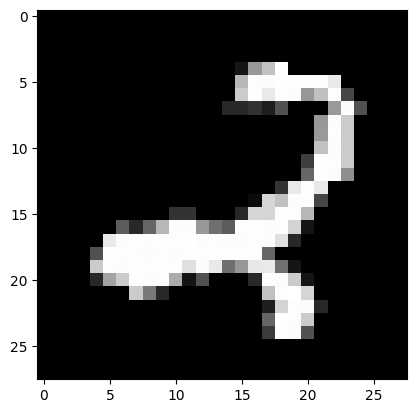

In [14]:
plt.imshow(features[0].cpu().squeeze(), cmap='gist_gray')

In [15]:
class DigitClassifier(nn.Module):
    def __init__(self, num_classes, p=0.3):
        super(DigitClassifier, self).__init__()
        
        self.c1 = nn.Conv2d(
            in_channels=1,
            out_channels=16,
            kernel_size=(5, 5),
            stride=1,
            padding=0,
        )
        self.c2 = nn.Conv2d(
            in_channels=16, 
            out_channels=32, 
            kernel_size=(3, 3), stride=1, padding=0
        )
        
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        self.mp = nn.MaxPool2d(kernel_size=(2, 2))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        
    def relu_mp_dropout(self, x):
        x = self.relu(x)
        x = self.mp(x)
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self.c1(x)
        x = self.bn1(x)
        x = self.relu_mp_dropout(x)
        
        x = self.c2(x)
        x = self.bn2(x)
        x = self.relu_mp_dropout(x)
        
        x = x.view(x.size(0), -1)  
        x = self.fc1(x)
        x = self.relu(x)  
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output


In [16]:
model = DigitClassifier(len(classes))

In [17]:
for features, label in dataloader:
    break

In [18]:
model(features).shape

torch.Size([64, 10])

In [19]:
df, df_test = train_test_split(df, test_size=0.1, stratify=df['label'])

In [20]:
test_dataset = DigitDataset(df_test.drop(['label'], axis=1), df_test['label'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [21]:
EPOCHS = 100
patience = 20
train_losses, val_losses = [], []
kfold = StratifiedKFold(n_splits=5, shuffle=True)

best_overall_accuracy = 0.0
best_overall_loss = float('inf')
best_model_state = None

for fold, (train_idx, val_idx) in enumerate(kfold.split(df.index, df['label'])):
    print(f'Fold {fold + 1}/{kfold.n_splits}\n')

    df_train, df_val = df.iloc[train_idx], df.iloc[val_idx]

    train_dataset = DigitDataset(df_train.drop(['label'], axis=1), df_train['label'])
    val_dataset = DigitDataset(df_val.drop(['label'], axis=1), df_val['label'])

    train_data_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_data_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    model = DigitClassifier(len(classes))
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    best_accuracy = 0  
    best_epoch = 0

    for epoch in range(EPOCHS):
        model.train()
        curr_loss = 0
        for features, labels in train_data_loader:  
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            curr_loss += loss.item() * features.size(0)

        train_loss = curr_loss / len(train_data_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        curr_loss = 0
        correct_predictions = 0

        with torch.no_grad():
            for features, labels in val_data_loader: 
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                loss = loss_fn(outputs, labels)
                curr_loss += loss.item() * features.size(0)
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == labels).sum().item()

        val_loss = curr_loss / len(val_data_loader.dataset)
        val_losses.append(val_loss)
        accuracy = correct_predictions / len(val_data_loader.dataset)

        print(f'Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_accuracy = accuracy
            best_model_state = model.state_dict()
            print(f'Model improved and saved at epoch {epoch+1} with validation loss: {val_loss:.4f}, accuracy: {accuracy:.4f}')

        if accuracy > best_overall_accuracy or val_loss < best_overall_loss:
            best_overall_accuracy = accuracy
            best_overall_loss = val_loss
            best_model_state = model.state_dict()

        if epoch - best_epoch >= patience:
            print('Patience limit reached. Stopping training.')
            break
        
        scheduler.step()

if best_model_state:
    torch.save(best_model_state, 'best_model.bin')
    print("Best model across all folds saved.")


Fold 1/5

Epoch 1/100 - Train Loss: 0.4542, Validation Loss: 0.0933, Accuracy: 0.9705
Model improved and saved at epoch 1 with validation loss: 0.0933, accuracy: 0.9705
Epoch 2/100 - Train Loss: 0.2117, Validation Loss: 0.0803, Accuracy: 0.9757
Model improved and saved at epoch 2 with validation loss: 0.0803, accuracy: 0.9757
Epoch 3/100 - Train Loss: 0.1715, Validation Loss: 0.0725, Accuracy: 0.9788
Model improved and saved at epoch 3 with validation loss: 0.0725, accuracy: 0.9788
Epoch 4/100 - Train Loss: 0.1336, Validation Loss: 0.0546, Accuracy: 0.9836
Model improved and saved at epoch 4 with validation loss: 0.0546, accuracy: 0.9836
Epoch 5/100 - Train Loss: 0.1201, Validation Loss: 0.0531, Accuracy: 0.9837
Model improved and saved at epoch 5 with validation loss: 0.0531, accuracy: 0.9837
Epoch 6/100 - Train Loss: 0.1162, Validation Loss: 0.0575, Accuracy: 0.9829
Epoch 7/100 - Train Loss: 0.0996, Validation Loss: 0.0502, Accuracy: 0.9852
Model improved and saved at epoch 7 with va

In [22]:
best_model_path = 'best_model.bin'
model.load_state_dict(torch.load(best_model_path))
model.to(device) 

DigitClassifier(
  (c1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mp): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [23]:
def evaluate(data_loader):
    model.eval()
    
    losses = []
    correct_preds = 0
    num_examples = 0  

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, dim=1)  
            loss = loss_fn(outputs, labels)
            
            correct_preds += torch.sum(preds == labels).item()
            losses.append(loss.item())
            num_examples += labels.size(0) 

    average_loss = np.mean(losses)
    accuracy = correct_preds / num_examples 
    
    return accuracy, average_loss


evaluate(test_loader)

(0.9895238095238095, 0.03540444501612166)

In [24]:
def predict(data_loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for features in data_loader:  
            features = torch.tensor(features).to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, dim=1)
            predictions.append(preds.cpu())  
    predictions = torch.cat(predictions, dim=0)
    
    return predictions

In [25]:
df_submit = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_submit.loc[:, df_submit.columns != 'label'] = df_submit.loc[:, df_submit.columns != 'label'] / 255.0
submit_dataset = DigitDataset(df_submit)
submit_dataloader = DataLoader(submit_dataset, batch_size=64)

In [26]:
predictions = predict(submit_dataloader)

In [27]:
predictions_list = predictions.tolist()
df_submit['Label'] = predictions_list
df_submit['ImageId'] = range(1, len(df_submit) + 1)
df_submit = df_submit[['Label', 'ImageId']]
df_submit.to_csv('submission.csv', index=False)